# Implementation of Deep Convolutional GANs
Reference: https://arxiv.org/pdf/1511.06434.pdf

In [ ]:
! pip install wandb

     |████████████████████████████████| 1.7 MB 9.4 MB/s 
     |████████████████████████████████| 143 kB 67.3 MB/s 
     |████████████████████████████████| 180 kB 67.0 MB/s 
     |████████████████████████████████| 97 kB 8.0 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=a5a7a88da96d131146f386374a2d1b66d5f2ee054d43041fa9643e5eb2a3d809
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=2d288755573aa12af794c927d8028a7f9ae5641e75259d5336f2b7bccd615b78
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


In [ ]:
import wandb
wandb.init(project="DCGAN", entity="YOUR_ID", name="colab")

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
import numpy as np
import datetime
import os, sys
import glob
from PIL import Image
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [ ]:
file_id="1NE2NQvaNf_f_9iSUyWC28aQXSrDXK3r4"
file_name="data.zip"

In [ ]:
! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={file_id}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={file_id}" -O {file_name} && rm -rf /tmp/cookies.txt
! unzip {file_name}

In [ ]:
MODEL_NAME = 'DCGAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
IMAGE_DIM = (32, 32, 3)

In [ ]:
def get_sample_image(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(10, n_noise).to(DEVICE)
    y_hat = G(z).view(10, 3, 32, 32).permute(0, 2, 3, 1) # (100, 28, 28)
    result = (y_hat.detach().cpu().numpy()+1)/2.
    return result

In [ ]:
class Discriminator(nn.Module):
    """
        Convolutional Discriminator for MNIST
    """
    def __init__(self, in_channel=1, num_classes=1):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            # 28 -> 14
            nn.Conv2d(in_channel, 512, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            # 14 -> 7
            nn.Conv2d(512, 256, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            # 7 -> 4
            nn.Conv2d(256, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            # 
            nn.Conv2d(128, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool2d(1),
        )        
        self.fc = nn.Sequential(
            # reshape input, 128 -> 1
            # nn.Dropout(0.4),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x, y=None):
        y_ = self.conv(x)
        y_ = y_.view(y_.size(0), -1)
        y_ = self.fc(y_)
        return y_

In [ ]:
class Generator(nn.Module):
    """
        Convolutional Generator for MNIST
    """
    def __init__(self, out_channel=1, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        assert IMAGE_DIM[0] % 2**4 == 0, 'Should be divided 16'
        self.init_dim = (IMAGE_DIM[0] // 2**4, IMAGE_DIM[1] // 2**4)
        self.fc = nn.Sequential(
            nn.Linear(input_size, self.init_dim[0]*self.init_dim[1]*512),
            nn.ReLU(),
        )
        self.conv = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # x2
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # x2
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # x2
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # x2
            nn.ConvTranspose2d(128, out_channel, 4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )
        
    def forward(self, x, y=None):
        x = x.view(x.size(0), -1)
        y_ = self.fc(x)
        y_ = y_.view(y_.size(0), 512, self.init_dim[0], self.init_dim[1])
        y_ = self.conv(y_)
        return y_

In [ ]:
class CARS(Dataset):

    def __init__(self, data_path, transform=None):

        self.data_path = data_path
        self.transform = transform
        self.fpaths = sorted(glob.glob(os.path.join(data_path, '*.jpg')))

    def __getitem__(self, idx):
        img = self.transform(Image.open(self.fpaths[idx]))
        return img

    def __len__(self):
        return len(self.fpaths)

In [ ]:
D = Discriminator(in_channel=IMAGE_DIM[-1]).to(DEVICE)
G = Generator(out_channel=IMAGE_DIM[-1]).to(DEVICE)
# D.load_state_dict('D_dc.pkl')
# G.load_state_dict('G_dc.pkl')

In [ ]:
transform = transforms.Compose([transforms.Resize((IMAGE_DIM[0],IMAGE_DIM[1])),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                std=(0.5, 0.5, 0.5))
                               ]
)

In [ ]:
dataset = CARS(data_path='./img_align_celeba/', transform=transform)

In [ ]:
batch_size = 64

In [ ]:
data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=8)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
criterion = nn.BCELoss()
beta1 = 0.5
beta2 = 0.999

lr = 0.001 # 0.0002
D_opt = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))
G_opt = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))

In [ ]:
max_epoch = 10
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_noise = 100

In [ ]:
D_labels = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label to fake

In [ ]:
from tqdm import tqdm

! mkdir img_align_celeba_sample

for epoch in range(max_epoch):
    print('epochs = {}/{}'.format(epoch+1,max_epoch))
    loop = tqdm(enumerate(data_loader),total=len(data_loader))
    for idx, images in loop:
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels)

            D.zero_grad()
            G.zero_grad()
            G_loss.backward()
            G_opt.step()
        

        loop.set_postfix(D_loss=D_loss.item(), G_loss = G_loss.item())
        wandb.log({'Epoch': epoch+1, 'Step': step,'D loss': D_loss.item(), 'G Loss' : G_loss.item()})

        if step % 100 == 0:
            G.eval()
            img = get_sample_image(G, n_noise)
            wandb.log({'Generated Images' :[wandb.Image(img[0])]})
            if step % 1000==0:
                imsave('img_align_celeba_sample/{}_epoch_{}_step_{}.jpg'.format(MODEL_NAME, epoch+1, step), img[0])
            G.train()
            
        step += 1

    dt = datetime.datetime.now().strftime('%H:%M:%S')
    print('Epoch: {}/{}, Step: {}, D Loss: {:.4f}, G Loss: {:.4f}, Time:{}'.format(epoch+1, max_epoch, step, D_loss.item(), G_loss.item(), dt))
    
    
        

epochs = 1/10


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 3165/3165 [04:39<00:00, 11.33it/s, D_loss=0.656, G_loss=2.61]

Epoch: 1/10, Step: 3165, D Loss: 0.6561, G Loss: 2.6125, Time:14:01:18
epochs = 2/10



100%|██████████| 3165/3165 [04:29<00:00, 11.77it/s, D_loss=0.606, G_loss=3.6]

Epoch: 2/10, Step: 6330, D Loss: 0.6062, G Loss: 3.6042, Time:14:05:47
epochs = 3/10



100%|██████████| 3165/3165 [04:27<00:00, 11.81it/s, D_loss=0.296, G_loss=3.26]

Epoch: 3/10, Step: 9495, D Loss: 0.2956, G Loss: 3.2636, Time:14:10:15
epochs = 4/10



100%|██████████| 3165/3165 [04:28<00:00, 11.77it/s, D_loss=0.736, G_loss=2.47]

Epoch: 4/10, Step: 12660, D Loss: 0.7363, G Loss: 2.4739, Time:14:14:44
epochs = 5/10



100%|██████████| 3165/3165 [04:27<00:00, 11.81it/s, D_loss=0.874, G_loss=0.264]

Epoch: 5/10, Step: 15825, D Loss: 0.8740, G Loss: 0.2638, Time:14:19:13
epochs = 6/10



100%|██████████| 3165/3165 [04:28<00:00, 11.78it/s, D_loss=0.645, G_loss=3.89]

Epoch: 6/10, Step: 18990, D Loss: 0.6446, G Loss: 3.8900, Time:14:23:42
epochs = 7/10



100%|██████████| 3165/3165 [04:28<00:00, 11.77it/s, D_loss=0.766, G_loss=3.01]

Epoch: 7/10, Step: 22155, D Loss: 0.7660, G Loss: 3.0077, Time:14:28:11
epochs = 8/10



100%|██████████| 3165/3165 [04:28<00:00, 11.78it/s, D_loss=0.183, G_loss=2.29]

Epoch: 8/10, Step: 25320, D Loss: 0.1827, G Loss: 2.2933, Time:14:32:41
epochs = 9/10



100%|██████████| 3165/3165 [04:28<00:00, 11.77it/s, D_loss=0.619, G_loss=2.86]

Epoch: 9/10, Step: 28485, D Loss: 0.6190, G Loss: 2.8649, Time:14:37:10
epochs = 10/10



100%|██████████| 3165/3165 [04:28<00:00, 11.81it/s, D_loss=0.173, G_loss=5.55]

Epoch: 10/10, Step: 31650, D Loss: 0.1729, G Loss: 5.5469, Time:14:41:38


## Sample

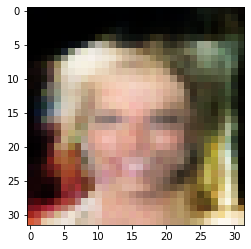

In [ ]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise)[0])

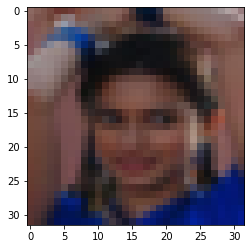

In [ ]:
# Real Image
t = Image.open(dataset.fpaths[999])
t = (transform(t).permute(1, 2, 0)+1)/2.
imshow(t)

In [ ]:
def save_checkpoint(state, file_name='checkpoint.pth.tar'):
    torch.save(state, file_name)

In [ ]:
# Saving params.
# torch.save(D.state_dict(), 'D_c.pkl')
# torch.save(G.state_dict(), 'G_c.pkl')
save_checkpoint({'epoch': epoch + 1,
                 'D':D.state_dict(),
                 'G':G.state_dict(),
                 'd_optim': D_opt.state_dict(),
                 'g_optim' : G_opt.state_dict()},
                'dcgan.pth.tar')